# Crossentropy method

This notebook will teach you to solve reinforcement learning problems with crossentropy method. We'll follow-up by scaling everything up and using neural network policy.

In [1]:
import sys, os
from tqdm import tqdm

if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash
    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

In [2]:
!pip install "gymnasium[toy_text]"

(314, {'prob': 1.0, 'action_mask': array([1, 1, 0, 0, 0, 0], dtype=int8)})


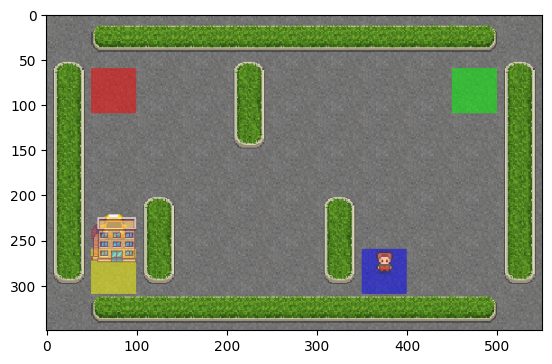

In [3]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

env = gym.make("Taxi-v3", render_mode="rgb_array")
print(env.reset(seed=0))
plt.imshow(env.render())


In [4]:
n_states = env.observation_space.n
n_actions = env.action_space.n

print(f"n_states={n_states}, n_actions={n_actions}")


n_states=500, n_actions=6


# Create stochastic policy

This time our policy should be a probability distribution.

```policy[s,a] = P(take action a | in state s)```

Since we still use integer state and action representations, you can use a 2-dimensional array to represent the policy.

Please initialize the policy __uniformly__, that is, probabililities of all actions should be equal.

In [5]:
def initialize_policy(n_states, n_actions):
    policy = np.full((n_states, n_actions), 1.0 / n_actions)

    return policy


policy = initialize_policy(n_states, n_actions)


In [6]:
print(n_states, n_actions)

500 6


In [7]:
assert type(policy) in (np.ndarray, np.matrix)
assert np.allclose(policy, 1.0 / n_actions)
assert np.allclose(np.sum(policy, axis=1), 1)

# Play the game

Just like before, but we also record all states and actions we took.

In [8]:
def generate_session(env, policy, t_max=10**4):
    """
    Play game until end or for t_max ticks.
    :param policy: an array of shape [n_states,n_actions] with action probabilities
    :returns: list of states, list of actions and sum of rewards
    """
    states, actions = [], []
    total_reward = 0.0

    s, _ = env.reset()

    for t in range(t_max):
        # Hint: you can use np.random.choice for sampling action
        # https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html

        a = np.random.choice(a=np.arange(0, n_actions), p=policy[s])
        # print(t, s, a)

        new_s, r, terminated, truncated, _ = env.step(a)

        # Record information we just got from the environment.
        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if terminated or truncated:
            break

    return states, actions, total_reward


In [9]:
ts, a, r = generate_session(env, policy)
print(type(a), type(ts))
print(r)
assert type(ts) == type(a) == list
assert len(ts) == len(a)
assert type(r) in [float, np.float64]


<class 'list'> <class 'list'>
-749.0


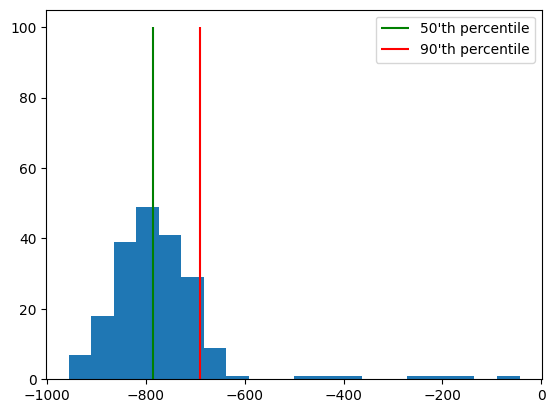

In [10]:
# let's see the initial reward distribution
import matplotlib.pyplot as plt
%matplotlib inline

sample_rewards = [generate_session(env, policy, t_max=1000)[-1] for _ in range(200)]

plt.hist(sample_rewards, bins=20)
plt.vlines([np.percentile(sample_rewards, 50)], [0], [100], label="50'th percentile", color='green')
plt.vlines([np.percentile(sample_rewards, 90)], [0], [100], label="90'th percentile", color='red')
plt.legend()

### Crossentropy method steps

In [11]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i]

    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions

    Please return elite states and actions in their original order
    [i.e. sorted by session number and timestep within session]

    If you are confused, see examples below. Please don't assume that states are integers
    (they will become different later).
    """

    reward_threshold = np.percentile(rewards_batch, percentile)

    # for states in states_batch:
    #     print(len(states))

    elite_states = []
    for i, states in enumerate(states_batch):
        if rewards_batch[i] >= reward_threshold:
            elite_states += states

    elite_actions = []
    for i, actions in enumerate(actions_batch):
        if rewards_batch[i] >= reward_threshold:
            elite_actions += actions

    # print(elite_states)
    # print(elite_actions)
    return elite_states, elite_actions


In [14]:
states_batch = [
    [1, 2, 3],     # game1
    [4, 2, 0, 2],  # game2
    [3, 1],        # game3
]

actions_batch = [
    [0, 2, 4],     # game1
    [3, 2, 0, 1],  # game2
    [3, 3],        # game3
]
rewards_batch = [
    3,  # game1
    4,  # game2
    5,  # game3
]

test_result_0 = select_elites(states_batch, actions_batch, rewards_batch, percentile=0)
test_result_30 = select_elites(
    states_batch, actions_batch, rewards_batch, percentile=30
)
test_result_90 = select_elites(
    states_batch, actions_batch, rewards_batch, percentile=90
)
test_result_100 = select_elites(
    states_batch, actions_batch, rewards_batch, percentile=100
)

assert np.all(test_result_0[0] == [1, 2, 3, 4, 2, 0, 2, 3, 1]) and np.all(
    test_result_0[1] == [0, 2, 4, 3, 2, 0, 1, 3, 3]
), "For percentile 0 you should return all states and actions in chronological order"
assert np.all(test_result_30[0] == [4, 2, 0, 2, 3, 1]) and np.all(
    test_result_30[1] == [3, 2, 0, 1, 3, 3]
), "For percentile 30 you should only select states/actions from two first"
assert np.all(test_result_90[0] == [3, 1]) and np.all(
    test_result_90[1] == [3, 3]
), "For percentile 90 you should only select states/actions from one game"
assert np.all(test_result_100[0] == [3, 1]) and np.all(
    test_result_100[1] == [3, 3]
), "Please make sure you use >=, not >. Also double-check how you compute percentile."

print("Ok!")


Ok!


In [12]:
def get_new_policy(elite_states, elite_actions):
    """
    Given a list of elite states/actions from select_elites,
    return a new policy where each action probability is proportional to

        policy[s_i,a_i] ~ #[occurrences of s_i and a_i in elite states/actions]

    Don't forget to normalize the policy to get valid probabilities and handle the 0/0 case.
    For states that you never visited, use a uniform distribution (1/n_actions for all states).

    :param elite_states: 1D list of states from elite sessions
    :param elite_actions: 1D list of actions from elite sessions

    """

    new_policy = np.zeros([n_states, n_actions])

    for i, state in enumerate(elite_states):
        new_policy[state][elite_actions[i]] += 1


    new_policy /= len(elite_states)
    for i in range(new_policy.shape[0]):
        sum = 0
        for j in range(new_policy.shape[1]):
            sum += new_policy[i][j]

        if (sum == 0):
            new_policy[i].fill(1 / n_actions)
        else:
            new_policy[i] /= sum

    return new_policy


In [14]:
elite_states = [1, 2, 3, 4, 2, 0, 2, 3, 1]
elite_actions = [0, 2, 4, 3, 2, 0, 1, 3, 3]

new_policy = get_new_policy(elite_states, elite_actions)

assert np.isfinite(
    new_policy
).all(), "Your new policy contains NaNs or +-inf. Make sure you don't divide by zero."
assert np.all(
    new_policy >= 0
), "Your new policy can't have negative action probabilities"
assert np.allclose(
    new_policy.sum(axis=-1), 1
), "Your new policy should be a valid probability distribution over actions"

reference_answer = np.array(
    [
        [1.0, 0.0, 0.0, 0.0, 0.0],
        [0.5, 0.0, 0.0, 0.5, 0.0],
        [0.0, 0.33333333, 0.66666667, 0.0, 0.0],
        [0.0, 0.0, 0.0, 0.5, 0.5],
    ]
)

# print(new_policy)

assert np.allclose(new_policy[:4, :5], reference_answer)

print("Ok!")


Ok!


# Training loop
Generate sessions, select N best and fit to those.

In [15]:
from IPython.display import clear_output


def show_progress(rewards_batch, log, percentile, reward_range=[-990, +10]):
    """
    A convenience function that displays training progress.
    No cool math here, just charts.
    """

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])

    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label="Mean rewards")
    plt.plot(list(zip(*log))[1], label="Reward thresholds")
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range)
    plt.vlines(
        [np.percentile(rewards_batch, percentile)],
        [0],
        [100],
        label="percentile",
        color="red",
    )
    plt.legend()
    plt.grid()
    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    plt.show()


In [16]:
# reset policy just in case
policy = initialize_policy(n_states, n_actions)


mean reward = -27.512, threshold=6.000


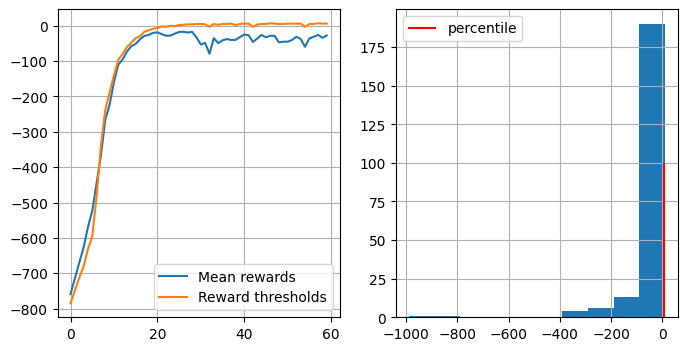

100%|██████████| 60/60 [00:22<00:00,  2.68it/s]


In [17]:
n_sessions = 250  # sample this many sessions
percentile = 50  # discard this percentage of sessions with lowest rewards
learning_rate = 0.5  # how quickly the policy is updated, on a scale from 0 to 1

log = []

for i in tqdm(range(60)):
    sessions = [ generate_session(env, policy) for i in range(n_sessions) ]

    states_batch, actions_batch, rewards_batch = zip(*sessions)

    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)

    new_policy = get_new_policy(elite_states, elite_actions)

    policy = learning_rate * new_policy + (1 - learning_rate) * policy

    # display results on chart
    show_progress(rewards_batch, log, percentile)


In [20]:
%time

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 10.3 µs


# Homework part I

### Tabular crossentropy method

You may have noticed that the taxi problem quickly converges from -100 to a near-optimal score and then descends back into -50/-100. This is in part because the environment has some innate randomness. Namely, the starting points of passenger/driver change from episode to episode.

### Tasks
- __1.1__ (2 pts) Find out how the algorithm performance changes if you use a different `percentile` and/or `n_sessions`. Provide here some figures so we can see how the hyperparameters influence the performance.
- __1.2__ (1 pts) Tune the algorithm to end up with positive average score.

It's okay to modify the existing code.


In [51]:
from IPython.display import clear_output


def show_full_progress(ax, title, log):
    ax.plot(list(zip(*log))[0], label="Mean rewards")
    ax.plot(list(zip(*log))[1], label="Reward thresholds")
    ax.legend()
    ax.grid()
    ax.set_title(title)



100%|██████████| 100/100 [01:45<00:00,  1.06s/it]


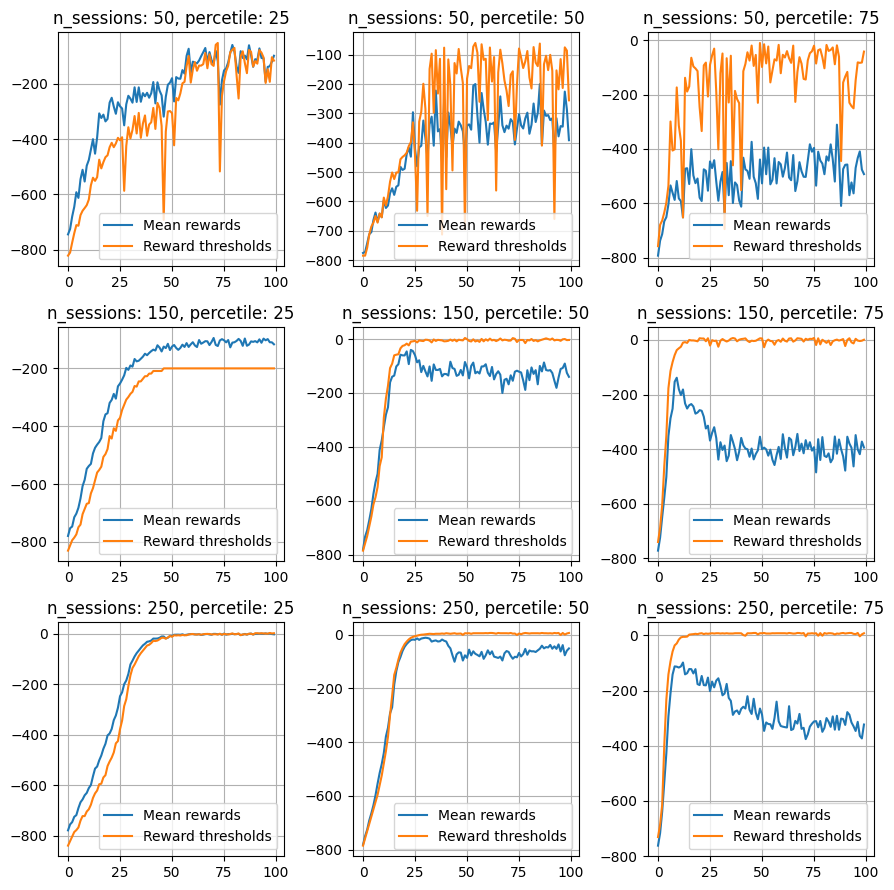

In [52]:
def generate_logs(n_sessions, percentile, learning_rate, env):
    policy = initialize_policy(n_states, n_actions)
    log = []
    for i in tqdm(range(100)):
        sessions = [ generate_session(env, policy) for i in range(n_sessions) ]
        states_batch, actions_batch, rewards_batch = zip(*sessions)

        mean_reward = np.mean(rewards_batch)
        threshold = np.percentile(rewards_batch, percentile)
        log.append([mean_reward, threshold])

        elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)
        new_policy = get_new_policy(elite_states, elite_actions)
        policy = learning_rate * new_policy + (1 - learning_rate) * policy
    return log


n_sessions = np.arange(50, 251, 100)  # sample this many sessions
percentiles = np.arange(25, 76, 25)  # discard this percentage of sessions with lowest rewards
learning_rate = 0.5  # how quickly the policy is updated, on a scale from 0 to 1

logs = []

fig, axes = plt.subplots(n_sessions.shape[0], percentiles.shape[0], figsize=(n_sessions.shape[0] * 3, percentiles.shape[0] * 3))

for i, sessions in enumerate(n_sessions):
    for j, percentile in enumerate(percentiles):
        title = f"n_sessions: {sessions}, percetile: {percentile}"
        log = generate_logs(sessions, percentile, learning_rate, env)
        show_full_progress(axes[i][j], title, log)

fig.tight_layout()
plt.show()

#### Solution
First, we train the model using a high percentile threshold and a large number of sessions. This allows us to quickly achieve good model quality. After that, we increase the number of sessions and lower the percentile threshold. This helps the model focus on selecting only high-quality actions across all states, further improving its performance. Additionally, using a large number of sessions helps to reduce the impact of randomness in the results.

mean reward = -31.728, threshold=-19.500


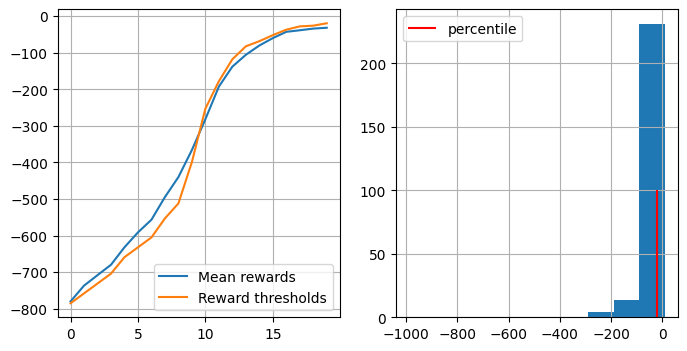

100%|██████████| 20/20 [00:35<00:00,  1.76s/it]


In [64]:
n_sessions = 250  # sample this many sessions
percentile = 50  # discard this percentage of sessions with lowest rewards
learning_rate = 0.5  # how quickly the policy is updated, on a scale from 0 to 1

log = []
policy = initialize_policy(n_states, n_actions)
for i in tqdm(range(20)):
    sessions = [ generate_session(env, policy) for i in range(n_sessions) ]

    states_batch, actions_batch, rewards_batch = zip(*sessions)

    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)

    new_policy = get_new_policy(elite_states, elite_actions)

    policy = learning_rate * new_policy + (1 - learning_rate) * policy

    # display results on chart
    show_progress(rewards_batch, log, percentile)


mean reward = 5.302, threshold=2.000


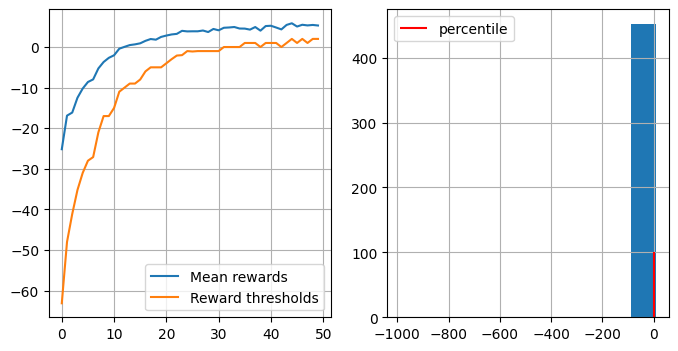

100%|██████████| 50/50 [00:40<00:00,  1.25it/s]


In [65]:
n_sessions = 500  # sample this many sessions
percentile = 10  # discard this percentage of sessions with lowest rewards
learning_rate = 0.5  # how quickly the policy is updated, on a scale from 0 to 1

log = []
for i in tqdm(range(50)):
    sessions = [ generate_session(env, policy) for i in range(n_sessions) ]

    states_batch, actions_batch, rewards_batch = zip(*sessions)

    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)

    new_policy = get_new_policy(elite_states, elite_actions)

    policy = learning_rate * new_policy + (1 - learning_rate) * policy

    # display results on chart
    show_progress(rewards_batch, log, percentile)


### Reflecting on results

You may have noticed that the taxi problem quickly converges from less than -1000 to a near-optimal score and then descends back into -50/-100. This is in part because the environment has some innate randomness. Namely, the starting points of passenger/driver change from episode to episode.

In case CEM failed to learn how to win from one distinct starting point, it will simply discard it because no sessions from that starting point will make it into the "elites".

To mitigate that problem, you can either reduce the threshold for elite sessions (duct tape way) or change the way you evaluate strategy (theoretically correct way). For each starting state, you can sample an action randomly, and then evaluate this action by running _several_ games starting from it and averaging the total reward. Choosing elite sessions with this kind of sampling (where each session's reward is counted as the average of the rewards of all sessions with the same starting state and action) should improve the performance of your policy.


### You're not done yet!

Go to [`./deep_crossentropy_method.ipynb`](./deep_crossentropy_method.ipynb) for a more serious task